In [13]:

import pandas as pd
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt 

In [14]:
header = ["age","workclass","fnlwgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","target"]


In [15]:

df = pd.read_csv("adult.csv", header = None)

In [16]:
df.columns = header

In [17]:
df.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
def handle_missing_data(df):
    
    """
    This function will replace all ' ?' values from data frame with maximum occuring
    from attribute from that particular attribute
    """
    for col in df.columns:
        col_set = df[col]
        counts = {}
        cnt = 0
        for attribute in col_set.unique():
            counts[attribute] = 0
            if attribute == ' ?':
                cnt += 1
        if not cnt:
            continue
        for attribute in col_set:
            counts[attribute]+=1
        max_freq = ' ?'
        for attribute in col_set:
            if counts[max_freq]<counts[attribute]:
                max_freq = attribute
        for i in range(len(df[col])):
            if df[col][i] == ' ?':
                df[col][i] = max_freq
    return df
            
        

In [7]:
df = handle_missing_data(df) #  Missing value modified

<ipython-input-6-be94e4e7226c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = max_freq


In [8]:
def split_data_random(df):
    shuffle_df = df.sample(frac = 1)
    train_size = int(0.8*len(df))
    train = shuffle_df[:train_size]
    test = shuffle_df[train_size:]
    
    return train, test

In [9]:
def split_data_for_pruning(df):
    shuffle_df = df.sample(frac = 1)
    train_size = int(0.6*len(df))
    val_size = int(0.8*len(df))
    train = shuffle_df[:train_size]
    test = shuffle_df[train_size:val_size]
    val = shuffle_df[val_size:]
    
    return train, val, test

In [10]:
train, test = split_data_random(df)

In [11]:

def newList_from_df(df):
    newList = []
    for i in range(len(df)):
        blankList = []
        newList.append(blankList)
    i = 0
    for col in df.columns:
        i = 0
        for attribute in df[col]:
            newList[i].append(attribute)
            i = i + 1
    return newList


In [12]:
training_data = newList_from_df(train)
testing_data = newList_from_df(test)

In [13]:
def unique_vals(rows,col):
    """Find the unique values for a column in a dataset"""
    return set([row[col] for row in rows])

In [14]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset"""
    counts = {}
    for row in rows:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label]+=1
    return counts


In [15]:
def is_numeric(value):
    """Test if a value is of type numeric"""
    return isinstance(value, int) or isinstance(value, float)

In [16]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 13 for native_country) and a
    'column value' (e.g., United States). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question.
    """
    
    def __init__(self, column, value):
        self.column = column
        self.value = value
    def match(self, example):
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value
    
    def __repr__(self):
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s ?" %(header[self.column],condition,str(self.value))

In [17]:
def partition(rows,question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [],[]
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [18]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows """
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl]/(float(len(rows)))
        impurity -= prob_of_lbl**2
    return impurity
        

In [19]:
def info_gain(left, right, curr):
    prob_left = float(len(left)/(len(left)+len(right)))
    return curr - prob_left*gini(left) - (1 - prob_left)*gini(right)

In [20]:
true_rows, false_rows = partition(training_data,Question(3,' Bachelors'))
info_gain(true_rows,false_rows, gini(training_data))

0.012181201088938498

In [21]:
def find_best_split(rows):
    """
    finds the best split by iterating over all possible feature/values
    and calculating the information gain.
    """
    
    best_gain = 0.0 # keep track of the best information gain
    best_question = None # keep a track for best question corresponding to best_gain
    
    current_uncertinity = gini(rows)    
    for col in range(len(rows[0]) - 1):
        
        values = unique_vals(rows,col)
        
        for val in values:
            
            ques = Question(col,val)
            true_rows, false_rows = partition(rows, ques)
            
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue
                
            gain = info_gain(true_rows, false_rows, current_uncertinity)
            
            if gain >= best_gain:
                best_gain, best_question = gain, ques
    return best_gain, best_question
            
            

In [22]:
# best_gain, best_question = find_best_split(training_data)
# best_question

In [23]:
class Leaf:
    """
    A Leaf node classification data.
    
    This holds a dictionary of class e.g ">=50K" --> number of times it
    appears in the rows from the training data that reach this leaf.
    """
    
    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [24]:
class Decision_Node:
    """
    A Decision Node asks a question.
    
    This holds a reference to the question, and to the two child nodes.
    """
    
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.count = {' >50K':0, ' <=50K':0}

In [25]:
def build_tree(rows):
    
    gain, question = find_best_split(rows)
    
    """
    If there is no gain in spliting then juts make it a Leaf
    """
    if gain == 0:
        return Leaf(rows)
    
    true_rows, false_rows = partition(rows, question)
    
    """
    recuresively build tree true and false branch
    """
    true_branch = build_tree(true_rows)
    false_branch = build_tree(false_rows)
    
    return Decision_Node(question, true_branch, false_branch)

In [26]:
def build_tree_max_depth(rows,curr_depth, max_depth):
    
    gain, question = find_best_split(rows)
    
    """
    If there is no gain in spliting then juts make it a Leaf
    or if it reaches the max_depth make it a leaf
    """
    if gain == 0 or curr_depth == max_depth:
        return Leaf(rows)
    
    true_rows, false_rows = partition(rows, question)
    
    """
    recuresively build tree true and false branch
    """
    true_branch = build_tree_max_depth(true_rows, curr_depth + 1, max_depth)
    false_branch = build_tree_max_depth(false_rows, curr_depth + 1, max_depth)
    
    return Decision_Node(question, true_branch, false_branch)

In [27]:
def print_tree(node, spacing=""):
    
    if isinstance(node, Leaf):
        print(spacing + "Predict",node.predictions)
        return 
    
    print(spacing + str(node.question))
    
    print(spacing + '--> True')
    left_height = print_tree(node.true_branch, spacing + " ")
    
    print(spacing + '--> False')
    right_height = print_tree(node.false_branch, spacing + " ")
    
    

In [28]:
def classify(row,node):
    
    if isinstance(node,Leaf):
        return node.predictions
    
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [29]:
def update_decision_count(node):
    
    """
    This function will update_decision_count for a given tree, i.e the 
    number of >50K and <=50K correspondind to subtree of each node
    """
    
    if isinstance(node, Leaf):
        
        leaf_gT, leaf_lT = 0, 0
        if ' >50K' in node.predictions:
            leaf_gT = node.predictions[' >50K']
        if ' <=50K' in node.predictions:
            leaf_lT = node.predictions[' <=50K']
        return leaf_gT, leaf_lT;
    
    true_gT, true_lT = update_decision_count(node.true_branch)
    false_gT, false_lT = update_decision_count(node.false_branch)
    
    node.count[' >50K'] = true_gT + false_gT
    node.count[' <=50K'] = true_lT + false_lT
    
    return node.count[' >50K'], node.count[' <=50K']
    

In [30]:
def predict_accuracy(my_tree,testing_data):
    correct_count = 0.0
    for row in testing_data:
        prediction = classify(row,my_tree)
        list_pred = list(prediction)
        
        cnt_gT = 0.0
        cnt_lT = 0.0
        
        if len(list_pred) == 2:
            cnt_lT+=prediction[' <=50K']
            cnt_gT+=prediction[' >50K']
        else:
            if ' <=50K' in list_pred:
                cnt_lT+=prediction[' <=50K']
            elif ' >50K' in list_pred:
                cnt_gT+=prediction[' >50K']   
        
        if ' >50K' == row[-1]:
            correct_count += int((cnt_gT)/(cnt_lT+cnt_gT))
        elif ' <=50K' == row[-1]:
            correct_count += int((cnt_lT)/(cnt_lT+cnt_gT))
        
    return 100.0*(correct_count/len(testing_data))

In [31]:
def tree_depth(node):
    
    if isinstance(node,Leaf):
        return 1
    return 1 + max(tree_depth(node.true_branch), tree_depth(node.false_branch))

In [32]:
def return_best_tree(df):
    
    best_tree = None
    best_depth = 0.0
    sum_of_accuracy = 0.0
    best_accuracy = 0.0
    
    plot_x = []
    plot_y = []
    
    for i in range(10):
        
        """
        Keep taking input unless maximum accuracy achived
        """
#         max_depth = int(input("Give a max_depth:"))
        max_depth = -1;
        
#         train, test = split_data_random(df)
        train, test = split_data_random(df[:4000]) # uncomment to use for lesser data as 40K of instances will take huge time 
        training_data = newList_from_df(train)
        testing_data = newList_from_df(test)
        
        my_tree_ = build_tree(training_data)
        
        new_accuracy = predict_accuracy(my_tree_,testing_data)
                
        sum_of_accuracy += new_accuracy
        
        plot_x.append(tree_depth(my_tree_))
        plot_y.append(new_accuracy)
        
        if new_accuracy > best_accuracy:
            best_accuracy = new_accuracy
            best_tree = my_tree_
            
        
    return best_tree, (sum_of_accuracy)/10.0, plot_x,plot_y
    

# 1.Best Tree

In [34]:
best_tree, average_accuracy, plot_x, plot_y = return_best_tree(df)
update_decision_count(best_tree)
print("")
print("Best Depth = " + str(tree_depth(best_tree))+"," + "Best Accuracy = "+ str(predict_accuracy(best_tree,training_data)))


Best Depth = 38,Best Accuracy = 81.7068488943489


In [35]:
print(plot_x, plot_y)

[33, 40, 31, 31, 38, 34, 38, 35, 29, 37] [80.125, 80.25, 77.75, 79.375, 82.5, 79.5, 81.375, 80.5, 78.25, 79.875]


In [36]:
def plot_graph(plot_x, plot_y):
    """
    Here Plot of Depth Vs Accuracy 
    """
    plot = []
    for i in range(len(plot_x)):
        plot.append((plot_x[i],plot_y[i])) 
    plot.sort()
    
    for i in range(len(plot)):
        plot_x[i] = plot[i][0]
        plot_y[i] = plot[i][1]
    
    plt.plot(plot_x,plot_y)
    plt.xlabel('Depth of the Tree')
    plt.ylabel('Achieved Accuracy')
    plt.title('Depth Vs Accuracy')
    plt.show()

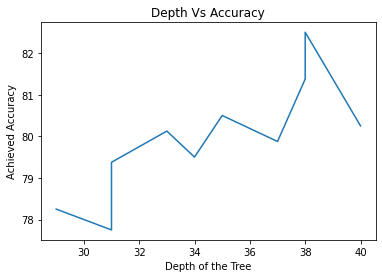

In [37]:
plot_graph(plot_x,plot_y)

In [38]:
print_tree(best_tree)

Is marital_status ==  Married-civ-spouse ?
--> True
 Is capital_gain >= 5178 ?
 --> True
  Is occupation ==  Farming-fishing ?
  --> True
   Is fnlwgt >= 214169 ?
   --> True
    Predict {' >50K': 1}
   --> False
    Predict {' <=50K': 2}
  --> False
   Is age >= 71 ?
   --> True
    Is hours_per_week >= 40 ?
    --> True
     Predict {' >50K': 1}
    --> False
     Predict {' <=50K': 1}
   --> False
    Is fnlwgt >= 82521 ?
    --> True
     Predict {' >50K': 125}
    --> False
     Is occupation ==  Craft-repair ?
     --> True
      Predict {' <=50K': 1}
     --> False
      Predict {' >50K': 9}
 --> False
  Is education_num >= 12 ?
  --> True
   Is capital_loss >= 1848 ?
   --> True
    Predict {' >50K': 46}
   --> False
    Is occupation ==  Exec-managerial ?
    --> True
     Is hours_per_week >= 25 ?
     --> True
      Is capital_gain >= 5013 ?
      --> True
       Predict {' <=50K': 2}
      --> False
       Is age >= 48 ?
       --> True
        Is age >= 90 ?
        --> Tr

              --> True
               Is fnlwgt >= 209642 ?
               --> True
                Predict {' >50K': 5}
               --> False
                Is workclass ==  Private ?
                --> True
                 Is fnlwgt >= 114495 ?
                 --> True
                  Is fnlwgt >= 117674 ?
                  --> True
                   Is hours_per_week >= 45 ?
                   --> True
                    Predict {' >50K': 3}
                   --> False
                    Is fnlwgt >= 133461 ?
                    --> True
                     Predict {' <=50K': 1}
                    --> False
                     Predict {' >50K': 1}
                  --> False
                   Predict {' <=50K': 1}
                 --> False
                  Predict {' >50K': 3}
                --> False
                 Is race ==  White ?
                 --> True
                  Is hours_per_week >= 59 ?
                  --> True
                   Predict {' 

# 2. Best Height Possible over 20 possible Depth and max_depth Input taken from the user

In [40]:
def return_best_depth(df):
    
    best_tree = None
    best_depth = 0.0
    sum_of_accuracy = 0.0
    best_accuracy = 0.0
    
    plot_x = []
    plot_y = []
    infinity = 100; ### edit for more than hundread if you want
    
    for i in range(20):
        
        """
        Keep taking input unless maximum accuracy achived
        """
        max_depth = int(input("Give a max_depth:"))
#         max_depth = -1;
        
#         train, test = split_data_random(df)
        train, test = split_data_random(df[:4000]) # uncomment to use for lesser data as 40K of instances will take huge time 
        training_data = newList_from_df(train)
        testing_data = newList_from_df(test)
        
        if max_depth == -1:
            max_depth = infinity
            
        my_tree_ = build_tree_max_depth(training_data,1, max_depth)
        
        new_accuracy = predict_accuracy(my_tree_,testing_data)
                
        sum_of_accuracy += new_accuracy
        
        plot_x.append(tree_depth(my_tree_))
        plot_y.append(new_accuracy)
        
        if new_accuracy > best_accuracy:
            best_accuracy = new_accuracy
            best_tree = my_tree_
            
        
    return tree_depth(best_tree), plot_x,plot_y

In [ ]:
best_depth, depth_x, acc_y = return_best_depth(df)
print("Best Depth Obtained:"+ str(best_depth))
plot_graph(depth_x, acc_y)

Give a max_depth:1
Give a max_depth:12
Give a max_depth:3


In [ ]:
def pruning_result(tree,training_data,validation_data):
    
    if len(training_data) == 0 or len(validation_data)==0:
        return tree
    acc_dT = predict_accuracy(tree, validation_data)
    new_Leaf = Leaf(training_data)
    acc_leaf = predict_accuracy(new_Leaf,validation_data)
    
    if acc_leaf >= acc_dT :
        return new_Leaf
    else:
        return tree
    

In [ ]:
def post_pruning(tree,training_data,validation_data):
    
    true_branch, false_branch = tree.true_branch, tree.false_branch
    
    if isinstance(true_branch,Leaf) and isinstance(false_branch,Leaf):
        return pruning_result(tree, training_data, validation_data)
    
    else:
        
        train_true, train_false = partition(training_data, tree.question)
        valid_true, valid_false = partition(validation_data, tree.question)
        
        if not isinstance(true_branch, Leaf):
            
            tree.true_branch = post_pruning(true_branch, train_true, valid_true)
        
        if not isinstance(false_branch, Leaf):
            
            tree.false_branch = post_pruning(false_branch, train_false, valid_false)

        return pruning_result(tree, training_data, validation_data)
        

# Pruning Operation to be performed by creating a tree of best_depth obtained from part 2

In [ ]:
trainP,valP= split_data_random(df[4000:8000])
trainingP_data, validationP_data = newList_from_df(trainP), newList_from_df(valP)

In [ ]:
tree_to_be_prunned = build_tree_max_depth(trainingP_data,1,best_depth)

In [ ]:

print("accuracy_on_training_data_before_prunning: "+ str(predict_accuracy(tree_to_be_prunned,trainingP_data)))
tree_prunned = post_pruning(tree_to_be_Prunned, trainingP_data, validationP_data)
print("accuracy_on_training_data_after_prunning: "+ str(predict_accuracy(tree_prunned,trainingP_data)))

In [ ]:
print_tree(tree_pruned) ## printing prunned tree